<a href="https://colab.research.google.com/github/wc6255/CAP-4630/blob/master/HW4/HW4Problem3A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Adaption of "Fine-tuning VGG16" on ResNet50

This implementation uses 2 hidden layers:

2 consectuve layers of size 256 using the ReLu function

1 output layer using sigmoid function

This is based on section 5.3 *Using a pretrained convnet* of the book *Deep learning with Python* by Francois Chollet. I have made several changes to the code. I use the data that is already provided by Google. I don't download the data from Kaggle as in the deep learning book.

## Feature extraction

Feature extraction consists of using the representations learned by a previous network to extract interesting features from new samples. These features are then run through a new classifier, which is trained from scratch.

We will use here the convolutional base of the VGG16 model to extract the features. We will feed these features to a densely connected classifier with dropout. We will fine-tune some layers.

## Download the data

Download the example data, a zip. of 2,000 JPG pictures of cats and dogs and extract it locally in ```/tmp```.



In [1]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2020-04-20 01:38:09--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.143.128, 2a00:1450:4013:c08::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.143.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   138MB/s    in 0.5s    

2020-04-20 01:38:10 (138 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

Note that the data provided by Google does not have a test set.

In [0]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

## Build network with ResNet50 convolution base and custom densely connected layers

### Load the convolutional base

In [4]:
from keras.applications import ResNet50

conv_base = ResNet50(
    weights='imagenet', 
    include_top=False, 
    input_shape=(150, 150, 3))
conv_base.summary()

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 3s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 75, 75, 64)   256         conv1[0][0]                      
__________________________

### Freeze the convolutional base

In [0]:
conv_base.trainable = False

### Concatenate the convolutional base and densely connected layers

In [0]:
from keras import layers
from keras import models
from keras import optimizers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
#model.add(layers.Dropout(0.1))
model.add(layers.Dense(1, activation='sigmoid'))

In [8]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 5, 5, 2048)        23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               13107456  
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 36,761,217
Trainable params: 13,173,505
Non-trainable params: 23,587,712
_________________________________________________________________


## Train the model end to end with frozen convolutional base

In [9]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

# data augmentation

train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

# compile model

model.compile(
    loss='binary_crossentropy', 
    optimizer=optimizers.RMSprop(lr=2e-5), 
    metrics=['acc'])

# train

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 27s 267ms/step - loss: 0.3843 - acc: 0.8300 - val_loss: 0.7736 - val_acc: 0.5000
Epoch 2/30
100/100 [==============================] - 17s 169ms/step - loss: 0.2657 - acc: 0.8825 - val_loss: 0.8336 - val_acc: 0.5000
Epoch 3/30
100/100 [==============================] - 17s 172ms/step - loss: 0.2159 - acc: 0.9030 - val_loss: 0.7094 - val_acc: 0.4970
Epoch 4/30
100/100 [==============================] - 17s 174ms/step - loss: 0.2115 - acc: 0.9145 - val_loss: 0.6633 - val_acc: 0.4970
Epoch 5/30
100/100 [==============================] - 17s 174ms/step - loss: 0.2248 - acc: 0.9140 - val_loss: 0.6937 - val_acc: 0.4970
Epoch 6/30
100/100 [==============================] - 17s 172ms/step - loss: 0.2003 - acc: 0.9230 - val_loss: 0.7693 - val_acc: 0.5000
Epoch 7/30
100/100 [==============================] - 17s 172ms/step - loss: 0.2005 - acc: 0.9235 - val_lo

## Display curves of loss and accuracy during training

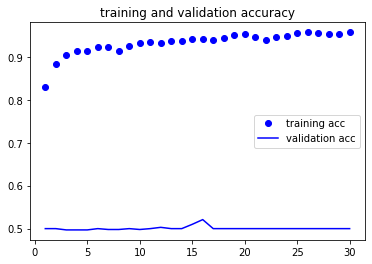

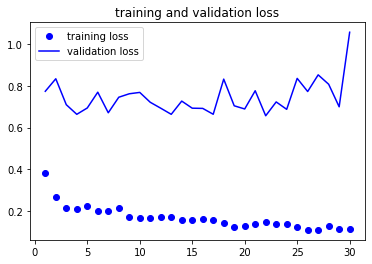

In [10]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

## Fine-tuning

In [0]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

In [12]:
# compile model

model.compile(
    loss='binary_crossentropy',
    #
    # choose a smaller learning rate
    #
    optimizer=optimizers.RMSprop(lr=1e-5), 
    metrics=['acc'])

# train

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/100
100/100 [==============================] - 22s 218ms/step - loss: 0.1017 - acc: 0.9585 - val_loss: 1.7606 - val_acc: 0.4970
Epoch 2/100
100/100 [==============================] - 18s 178ms/step - loss: 0.1064 - acc: 0.9625 - val_loss: 2.2710 - val_acc: 0.4170
Epoch 3/100
100/100 [==============================] - 18s 175ms/step - loss: 0.1112 - acc: 0.9575 - val_loss: 4.7343 - val_acc: 0.4450
Epoch 4/100
100/100 [==============================] - 18s 176ms/step - loss: 0.0871 - acc: 0.9630 - val_loss: 2.4027 - val_acc: 0.4640
Epoch 5/100
100/100 [==============================] - 18s 175ms/step - loss: 0.0966 - acc: 0.9645 - val_loss: 1.7811 - val_acc: 0.5030
Epoch 6/100
100/100 [==============================] - 18s 176ms/step - loss: 0.0830 - acc: 0.9680 - val_loss: 1.3371 - val_acc: 0.5700
Epoch 7/100
100/100 [==============================] - 18s 176ms/step - loss: 0.0855 - acc: 0.9670 - val_loss: 1.1059 - val_acc: 0.7320
Epoch 8/100
100/100 [===========================

## Display learning curves during fine-tuning

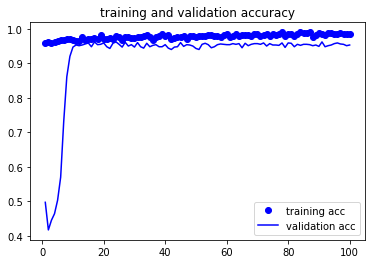

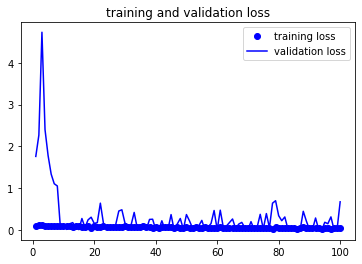

In [13]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

This looks like overfitting. I should try  adding dropout for the densely connected layer.

## Print out validation loss and accuracy

In [0]:
val_loss, val_acc = model.evaluate_generator(validation_generator, steps=50)

In [15]:
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

Validation loss: 0.298856258392334
Validation accuracy: 0.953000009059906


## Save the model

In [0]:
model_fname = 'cats_and_dogs_small_4copy.h5' 
model.save(model_fname)

In [18]:
from google.colab import drive

drive.mount('/content/gdrive')



Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import torch
from torchvision import datasets, models, transforms
path = F"/content/gdrive/My Drive/{model_fname}" 
torch.save(model.save(model_fname), path)